In [1]:
import numpy as np
import mne
from scipy.io import loadmat
from braindecode import EEGClassifier
from braindecode.util import set_random_seeds
from braindecode.models import ShallowFBCSPNet, EEGNetv4, Deep4Net, HybridNet
from braindecode.models.util import models_dict
from skorch.dataset import ValidSplit
from skorch.callbacks import LRScheduler
import torch
import os

ModuleNotFoundError: No module named 'braindecode.training'

In [2]:
path1 = "./data/MT_2301_Ymke.mat"

data = loadmat(path1)['data']

In [3]:
print(f"Amount of samples: {len(data)} \nAmount of channels: {len(data[0])}")

Amount of samples: 1440699 
Amount of channels: 20


In [4]:
def mat_to_raw(path, sfreq=500):
    data = loadmat(path)['data'] # this requires the loadmat function from scipy.io
    ch_names = [f"ch{i}" for i in range(len(data[0]) - 1)]
    ch_types = ['eeg' for _ in range(len(data[0]) - 1)]
    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
    data_r = data[:, :-1]
    markers = data[:, -1]
    raw = mne.io.RawArray(data_r.T, info)
    return raw, markers

raw, markers = mat_to_raw(path1)

Creating RawArray with float64 data, n_channels=19, n_times=1440699
    Range : 0 ... 1440698 =      0.000 ...  2881.396 secs
Ready.


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


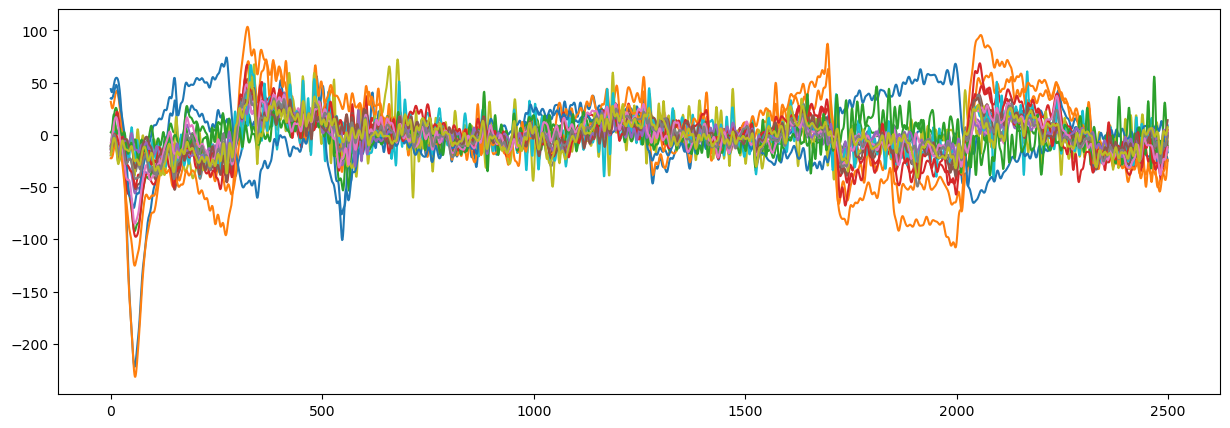

In [5]:
# apply band-pass filter
raw.filter(1, 40)

# Get a 5 second subset of the data
start = int(raw.info['sfreq'] * 5)  # Start 5 seconds in
stop = start + int(raw.info['sfreq'] * 5)  # End 5 seconds later
subset = raw.get_data(start=start, stop=stop)

# Plot the subset
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
plt.plot(subset.T)
plt.show()


In [6]:
# get value counts of markers
print(markers)
print(np.unique(markers, return_counts=True))

[0. 0. 0. ... 0. 0. 0.]
(array([0., 1., 2., 3., 4.]), array([1437359,     830,     835,     841,     834], dtype=int64))


In [7]:
def find_marker_starts(data):
  """
  Find the indices where markers start in a numpy array.

  Args:
    data: A numpy array of integers.

  Returns:
    A numpy array of shape (n_events, 2) where the first column is the index
    at which the marker starts, and the second column the marker it is about.
  """
  # Find the indices where the data changes from non-marker to marker.
  marker_starts = np.flatnonzero(np.diff(data) > 0) + 1

  # Get the markers at the start indices.
  markers = data[marker_starts]

  # Combine the start indices and markers into a single array.
  return np.vstack((marker_starts, markers)).T

# Example usage
data = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 5, 5, 5, 5, 5, 5, 5, 0, 0, 0])
result = find_marker_starts(data)
print(result)

[[ 4  1]
 [19  2]
 [27  5]]


In [8]:
# cast markers to int
markers = markers.astype(int)

marker_starts = find_marker_starts(markers)

In [9]:
marker_starts

array([[  19979,       1],
       [  24021,       2],
       [  28060,       4],
       [  32102,       3],
       [  36144,       1],
       [  40180,       2],
       [  44221,       3],
       [  48259,       4],
       [  52298,       4],
       [  56333,       2],
       [  60374,       1],
       [  64412,       3],
       [  68450,       3],
       [  72489,       2],
       [  76527,       4],
       [  80566,       1],
       [  84604,       1],
       [  88643,       4],
       [  92686,       2],
       [  96727,       3],
       [ 100766,       1],
       [ 104805,       4],
       [ 108842,       3],
       [ 112880,       2],
       [ 116919,       4],
       [ 120956,       3],
       [ 124996,       1],
       [ 129034,       2],
       [ 133072,       3],
       [ 137116,       4],
       [ 141157,       2],
       [ 145196,       1],
       [ 152667,       1],
       [ 156703,       2],
       [ 160741,       4],
       [ 164779,       3],
       [ 168819,       1],
 

In [10]:
# add column of 0s to middle of array
events = np.insert(marker_starts, 1, 0, axis=1)

In [11]:
events

array([[  19979,       0,       1],
       [  24021,       0,       2],
       [  28060,       0,       4],
       [  32102,       0,       3],
       [  36144,       0,       1],
       [  40180,       0,       2],
       [  44221,       0,       3],
       [  48259,       0,       4],
       [  52298,       0,       4],
       [  56333,       0,       2],
       [  60374,       0,       1],
       [  64412,       0,       3],
       [  68450,       0,       3],
       [  72489,       0,       2],
       [  76527,       0,       4],
       [  80566,       0,       1],
       [  84604,       0,       1],
       [  88643,       0,       4],
       [  92686,       0,       2],
       [  96727,       0,       3],
       [ 100766,       0,       1],
       [ 104805,       0,       4],
       [ 108842,       0,       3],
       [ 112880,       0,       2],
       [ 116919,       0,       4],
       [ 120956,       0,       3],
       [ 124996,       0,       1],
       [ 129034,       0,   

In [12]:
epochs = mne.Epochs(raw, events=events, event_id=None, tmin=0, tmax=5, baseline=None, preload=True)

Not setting metadata
321 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 321 events and 2501 original time points ...
0 bad epochs dropped


In [13]:
display(epochs)

X = epochs.get_data()
y = epochs.events[:, 2] - 1

Number of events,321
Events,1: 802: 803: 814: 80
Time range,0.000 – 5.000 s
Baseline,off


C:\Users\Fabia\AppData\Local\Temp\ipykernel_13544\699575072.py:3: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  X = epochs.get_data()


In [14]:
def stop_nb_execution():
    raise KeyboardInterrupt

# stop_nb_execution()

In [15]:
# split data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(256, 19, 2501)

(65, 19, 2501)

(256,)

(65,)

In [16]:


models_available = list(models_dict.keys())
print(*models_available, sep='\n')

ATCNet
Deep4Net
DeepSleepNet
EEGConformer
EEGITNet
EEGInception
EEGInceptionERP
EEGInceptionMI
EEGNetv1
EEGNetv4
EEGResNet
HybridNet
ShallowFBCSPNet
SleepStagerBlanco2020
SleepStagerChambon2018
SleepStagerEldele2021
TCN
TIDNet
USleep


In [17]:
cuda = torch.cuda.is_available()  # check if GPU is available
device = 'cuda' if cuda else 'cpu'
if cuda:
    torch.backends.cudnn.benchmark = True

seed = 20200220  # random seed to make results reproducible
set_random_seeds(seed=seed, cuda=cuda)

print(f"Device: {device}\nSeed: {seed}")

Device: cuda
Seed: 20200220


C:\Users\Fabia\miniconda3\envs\remoteeeg\lib\site-packages\braindecode\util.py:51: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


In [18]:
n_classes = len(np.unique(y))
classes = list(range(n_classes))
n_chans = X.shape[1]
input_window_samples = X.shape[2]

print(f"Classes: {classes}\nNumber of classes: {n_classes}\nNumber of channels: {n_chans}\nInput window samples: {input_window_samples}")

model = ShallowFBCSPNet(
    in_chans=n_chans,
    n_classes=n_classes,
    input_window_samples=input_window_samples,
    final_conv_length='auto',
)

print(model)

if cuda:
    model.cuda()
    print("Model on GPU")

Classes: [0, 1, 2, 3]
Number of classes: 4
Number of channels: 19
Input window samples: 2501


C:\Users\Fabia\miniconda3\envs\remoteeeg\lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'in_chans' is depreciated. Use 'n_chans' instead.
  warnings.warn(
C:\Users\Fabia\miniconda3\envs\remoteeeg\lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
C:\Users\Fabia\miniconda3\envs\remoteeeg\lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\Fabia\miniconda3\envs\remoteeeg\lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Layer (type (var_name):depth-idx)        Input Shape               Output Shape              Param #                   Kernel Shape
ShallowFBCSPNet (ShallowFBCSPNet)        [1, 19, 2501]             [1, 4]                    --                        --
├─Ensure4d (ensuredims): 1-1             [1, 19, 2501]             [1, 19, 2501, 1]          --                        --
├─Rearrange (dimshuffle): 1-2            [1, 19, 2501, 1]          [1, 1, 2501, 19]          --                        --
├─CombinedConv (conv_time_spat): 1-3     [1, 1, 2501, 19]          [1, 40, 2477, 1]          31,440                    --
├─BatchNorm2d (bnorm): 1-4               [1, 40, 2477, 1]          [1, 40, 2477, 1]          80                        --
├─Expression (conv_nonlin_exp): 1-5      [1, 40, 2477, 1]          [1, 40, 2477, 1]          --                        --
├─AvgPool2d (pool): 1-6                  [1, 40, 2477, 1]          [1, 40, 161, 1]           --                        [75, 1]
├─Express

In [19]:
lr = 0.0625 * 0.01
weight_decay = 0.8 * 0.001
batch_size = 64
n_epochs = 100

clf = EEGClassifier(
    model,
    criterion=torch.nn.CrossEntropyLoss,
    optimizer=torch.optim.AdamW,
    train_split=None,
    optimizer__lr=lr,
    optimizer__weight_decay=weight_decay,
    batch_size=batch_size,
    callbacks=[
        "accuracy",
        ("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1)),
    ],
    device=device,
    classes=classes,
    max_epochs=n_epochs,
)

clf.fit(X_train, y_train)

  epoch    train_accuracy    train_loss      lr     dur
-------  ----------------  ------------  ------  ------
      1            0.4961        1.8539  0.0006  0.2140
      2            0.6680        1.2966  0.0006  0.0385
      3            0.7500        0.9684  0.0006  0.0420
      4            0.8555        0.7943  0.0006  0.0350
      5            0.9297        0.6720  0.0006  0.0370
      6            0.9570        0.5462  0.0006  0.0370
      7            0.9844        0.4316  0.0006  0.0355
      8            0.9961        0.4028  0.0006  0.0355
      9            1.0000        0.3468  0.0006  0.0350
     10            1.0000        0.3145  0.0006  0.0360
     11            1.0000        0.2148  0.0006  0.0370
     12            1.0000        0.1910  0.0006  0.0370
     13            1.0000        0.1604  0.0006  0.0365
     14            1.0000        0.1508  0.0006  0.0380
     15            1.0000        0.1156  0.0006  0.0370
     16            1.0000        0.1279  0.0006 

<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_=============================================================================================================================================
  Layer (type (var_name):depth-idx)        Input Shape               Output Shape              Param #                   Kernel Shape
  ShallowFBCSPNet (ShallowFBCSPNet)        [1, 19, 2501]             [1, 4]                    --                        --
  ├─Ensure4d (ensuredims): 1-1             [1, 19, 2501]             [1, 19, 2501, 1]          --                        --
  ├─Rearrange (dimshuffle): 1-2            [1, 19, 2501, 1]          [1, 1, 2501, 19]          --                        --
  ├─CombinedConv (conv_time_spat): 1-3     [1, 1, 2501, 19]          [1, 40, 2477, 1]          31,440                    --
  ├─BatchNorm2d (bnorm): 1-4               [1, 40, 2477, 1]          [1, 40, 2477, 1]          80                        --
  ├─Expression (conv_nonlin_exp): 

In [20]:
# Evaluate the model
from sklearn.metrics import accuracy_score
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 63.08%


In [36]:
randx = np.random.rand(1, 19, 2501)
clf.predict(randx)

array([0], dtype=int64)

In [37]:
y_pred

array([1, 3, 1, 2, 0, 0, 3, 0, 3, 3, 3, 1, 3, 3, 0, 0, 2, 2, 2, 1, 3, 1,
       1, 1, 2, 3, 1, 3, 0, 1, 3, 0, 2, 3, 1, 3, 0, 1, 2, 2, 0, 3, 2, 1,
       3, 0, 1, 3, 2, 3, 2, 3, 2, 2, 0, 3, 0, 0, 0, 1, 3, 2, 2, 3, 1],
      dtype=int64)

In [32]:
X_test.shape

(65, 19, 2501)